In [1]:
import copy
import math
#import pygame
import itertools
import os
import wandb

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import zeta
from tqdm import tqdm

In [2]:
def periodic_range(a, b, L): # list of all the elements from a to b, considering the b.c.'s
    if a <= b:
        return list(range(a, b))
    else:
        return list(range(a, L))+list(range(0, b))
    
def periodic_distance(a, b, L): # distance between two coordinates, considering the b.c.'s
    return min(abs(a-b), abs((a+L)-b), abs(a-(b+L)))
    #return np.minimum(abs(a-b), abs((a+L)-b), abs(a-(b+L)))
    
def periodic_distance1(a, b, L): # distance between two coordinates, considering the b.c.'s
    return np.minimum(abs(a-b), abs((a+L)-b), abs(a-(b+L)))

def periodic_distance2(a, b, L):
    # Calculate the difference between coordinates, considering periodic boundaries
    diff = (a - b) % L
    # Apply the minimum distance considering both directions
    return np.minimum(diff, L - diff)

def get_random_neighboor(pos_x, pos_y, L): # random neighbor in the square surrounding a given cell
    choice_x, choice_y = 0, 0
    while choice_x == 0 and choice_y == 0:
        choice_x, choice_y = np.random.randint(3, size = 2) - 1
    return (pos_x + choice_x)%L, (pos_y + choice_y)%L

def power_law(beta, size = 1): # discrete power law sampler
    sign = (-1)**np.random.randint(2, size = size)
    x = np.random.zipf(beta, size)
    return sign*x

def power_law_cont(beta): # continuous power law sampler
    u = next(random_unif_numbers)#np.random.random(size = size)
    l = u**(1/(1-beta))
    return l

def power_law_boyer(beta): # continuous power law sampler
    u = next(random_unif_numbers)#np.random.random(size = size)
    l = ((1000**(1-beta)-1**(1-beta))*u + 1**(1-beta))**(1/(1-beta))
    return l

def distance_matrix(pos_x, pos_y, L): # matrix of distances between centers of the patches
    n = pos_x.shape[0]
    mat = np.zeros((n,n))
    for i in range(n):
        for j in range(i):
            mat[i,j] = np.sqrt((periodic_distance(pos_x[i], pos_x[j], L))**2 + (periodic_distance(pos_y[i], pos_y[j], L))**2)
            mat[j,i] = mat[i,j]

    return mat

def continuous_move(pos_x, pos_y, L, beta): # continuous move with radial symmetry
    l = power_law_boyer(beta)
    theta = 2*np.pi*next(random_unif_numbers)#np.random.random()
    l_x, l_y = l*np.cos(theta), l*np.sin(theta)
                    
    new_x, new_y = int(((pos_x+0.5) + l_x)%L), int(((pos_y+0.5) + l_y)%L)
    return new_x, new_y

def gauss_move(pos_x, pos_y, L, m, std):
    r = norm.rvs(loc = m, scale = std, size = 1)
    while r < 0:
        r = norm.rvs(loc = m, scale = std, size = 1)
        
    theta = 2*np.pi*next(random_unif_numbers)
    r_x, r_y = r*np.cos(theta), r*np.sin(theta)
    
    new_x, new_y = int(((pos_x+0.5) + r_x)%L), int(((pos_y+0.5) + r_y)%L)
    return new_x, new_y

def expon_move(pos_x, pos_y, L, m):
    r = expon.rvs(loc = 0, scale = m, size = 1)
        
    theta = 2*np.pi*next(random_unif_numbers)
    r_x, r_y = r*np.cos(theta), r*np.sin(theta)
    
    new_x, new_y = int(((pos_x+0.5) + r_x)%L), int(((pos_y+0.5) + r_y)%L)
    return new_x, new_y

In [3]:
#! wandb login f10b237d96ce3032483385fa304a0eed16a99927

In [4]:
L = 200
a = np.random.randint(0, L, size = 10)
b = np.random.randint(0, L, size = 10)

# Compute distances using both functions
distance1 = periodic_distance1(a, b, L)
distance2 = periodic_distance2(a, b, L)

# Print the results
print("Result using periodic_distance:", distance1)
print("Result using periodic_distance2:", distance2)

# Check if the results are the same
if np.array_equal(distance1, distance2):
    print("Both functions produce the same result.")
else:
    print("There is a discrepancy between the results.")

Result using periodic_distance: [31 38 64 28 64 53 67 32 37 58]
Result using periodic_distance2: [31 38 64 28 64 53 67 32 37 58]
Both functions produce the same result.


In [5]:
def NoMove_stationary(lambd, mu, sigma, K, lambd_p):
  b_stat = mu/lambd
  if b_stat<K:
    a_stat = (K - b_stat)/(1 + (lambd_p*K/sigma))
    return [a_stat, b_stat]
  elif b_stat>K:
    return [0, K]

def p(l, beta, p_0):
    if l==0:
        return p_0
    else:
        norm = zeta(beta, 1)
        return (1-p_0)*abs(l)**(-beta)/(2*norm)

def p1(l, beta, p_0):
    l = np.where(l!=0, l, np.inf)
    #if l==0:
    #    return p_0
    #else:
    norm = zeta(beta, 1)
    res = (1-p_0)*abs(l)**(-beta)/(2*norm)
    return np.where(res != 0, res, p_0)

def norm_gauss(m, std):
    som = 0
    for i in range(1, 10000):
        som += np.exp(-(i-m)**2/(2*std**2))
    
    som = som*2
    som += np.exp(-(0-m)**2/(2*std**2))
    
    return som

def p_gauss(l, m, std):
    res = np.exp(-(abs(l)-m)**2/(2*std**2))/norm_gauss_const
    return res

def p_exp(l, m):
    norm = (np.e**(1/m)+1)/(np.e**(1/m)-1)
    res = np.exp(-(abs(l)/m))/norm
    return res
    
def flux(a_t, i, j, beta, p_0):
    L = a_t.shape[0]
    som = 0
    for pos_x in range(L):
        for pos_y in range(L):
            l_x = periodic_distance(i, pos_x, L)
            l_y = periodic_distance(j, pos_y, L)
            som += p(l_x, beta, p_0)*p(l_y, beta, p_0)*a_t[pos_x, pos_y]
    
    return som

def flux1(a_t, i, j, beta, p_0):
    L = a_t.shape[0]
    pos_x = np.arange(L)
    pos_y = np.arange(L)
    l_x = periodic_distance1(i, pos_x, L)
    l_y = periodic_distance1(j, pos_y, L)
    p_x = p1(l_x, beta, p_0)
    p_y = p1(l_y, beta, p_0)
    return np.sum(np.outer(p_x, p_y) * a_t)

def flux2(a_t, i, j, beta, p_0):
    L = a_t.shape[0]
    pos_x = np.arange(L)
    pos_y = np.arange(L)
    l_x = periodic_distance2(i, pos_x, L)
    l_y = periodic_distance2(j, pos_y, L)
    #p_x = p1(l_x, beta, p_0)
    #p_y = p1(l_y, beta, p_0)
    p_x = p_gauss(l_x, m, std)
    p_y = p_gauss(l_y, m, std)
    #p_x = p_exp(l_x, m)
    #p_y = p_exp(l_y, m)
    
    return np.sum(np.outer(p_x, p_y) * a_t)

In [6]:
# Define the parameters
L = 200  # Size of the grid
i = 40   # Position i
j = 153   # Position j
beta = 2  # Parameter beta
p_0 = 0.8  # Parameter p_0

# Create a random grid a_t
a_t = np.random.rand(L, L)

# Call the flux and flux2 functions
result_flux = flux2(a_t, i, j, beta, p_0)
result_flux2 = flux(a_t, i, j, beta, p_0)

# Compare the results
if np.allclose(result_flux, result_flux2):
    print("Results of flux and flux1 are equal.")
else:
    print("Results of flux and flux1 are not equal.")
    
### FLUX AND FLUX2 ARE EQUAL, WHILE FLUX1 NOT

NameError: name 'm' is not defined

In [188]:
#run = wandb.init(project="Project-PMoLS-fou-mu-020")     # , entity="campagnolafesta"

config = dict(
    l_0=4, 
    sigma=0.5,
    mu=0.11,    
    R_0=10.48, 
    beta=1.7,                 
    T=100)              

#wandb.config = config
#wandb.config

In [233]:
lambd, mu, sigma, K, lambd_p = 1, config['mu'], config['sigma'], 1, 1
#a0, b0 = NoMove_stationary(lambd, mu, sigma, K, lambd_p)
a0 = 0.05
b0 = K - a0*(1 + (K*lambd_p)/sigma)
print("a0: ", a0)
print("b0: ", b0)

lambd0 = 1

l_0 = config['l_0']
R_0 = config['R_0']
R = R_0/np.sqrt(np.pi)

L = 9*l_0 # AUMENTO l
T = config['T'] # AUMENTO T
dt = 0.1 # DIMINUISCO DT
q = int(T/dt)

m = 26/R_0
std = 1/R_0

norm_gauss_const = norm_gauss(m, std)


'''
beta = config['beta']
if beta == 2:
    p_0 = 1 - (2/R_0) # checked doing the limit
else:
    p_0 = 1 - (1/R_0) + (1-R_0**(2-beta))/((2-beta)*R_0)
    '''

a = np.zeros((q,L,L))
b = np.zeros((q,L,L))
a[0, :, :] = a0

patch_map = np.zeros((L,L))
                     
for i in range(L):
    for j in range(L):
        if i%l_0==0 and j%l_0==0:
            patch_map[i, j] = 1
            a[0, i, j] = 0.25
            b[0, i, j] = b0

for t in tqdm(range(q-1)):
    for i in range(L):
        for j in range(L):
            move_out = lambd0*a[t, i, j]
            move_in = flux2(a[t], i, j, beta, p_0)
            reproduction = lambd*a[t, i, j]*b[t, i, j]
            death = mu*a[t, i, j]
            a[t+1, i, j] = a[t, i, j] + (-move_out+move_in+reproduction-death)*dt
            
            if i%l_0==0 and j%l_0==0:
                offspring = sigma*b[t, i, j]*(1-(a[t, i, j]+b[t, i, j])/K)
                predation = lambd_p*a[t, i, j]*b[t, i, j]
                b[t+1, i, j] = b[t, i, j] + (offspring-predation)*dt
                
print(m)

  0%|          | 3/999 [00:00<00:47, 21.12it/s]

a0:  0.05
b0:  0.85


100%|██████████| 999/999 [00:44<00:00, 22.35it/s]

2.480916030534351


In [234]:
'''
wandb.log({'l_0':config['l_0'], 'mu':config['mu'], 'R_0':config['R_0'], 'beta':config['beta'],
           'Predator stationary density': np.mean(a[-1]),
           'Prey stationary density': np.mean(b[-1])}
           )
run.finish()
'''

"\nwandb.log({'l_0':config['l_0'], 'mu':config['mu'], 'R_0':config['R_0'], 'beta':config['beta'],\n           'Predator stationary density': np.mean(a[-1]),\n           'Prey stationary density': np.mean(b[-1])}\n           )\nrun.finish()\n"

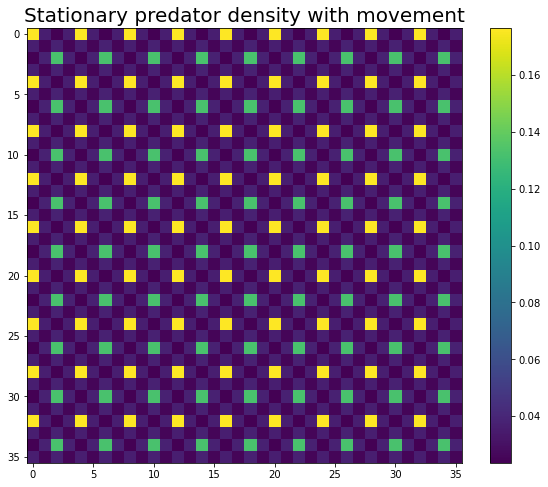

In [235]:
plt.figure(figsize = (10,8))
plt.title("Stationary predator density with movement", fontsize = 20)
plt.imshow(a[-1])
plt.colorbar()

In [236]:
'''
for i in range(5):
    for j in range(l_0+1):
        print(a[-1, i*l_0 + j, 0])
    print("\n")
    '''

'\nfor i in range(5):\n    for j in range(l_0+1):\n        print(a[-1, i*l_0 + j, 0])\n    print("\n")\n    '

In [237]:
'''
for i in range(5):
    for j in range(l_0+1):
        print(a[-1, 0, i*l_0 + j])
    print("\n")
    '''

'\nfor i in range(5):\n    for j in range(l_0+1):\n        print(a[-1, 0, i*l_0 + j])\n    print("\n")\n    '

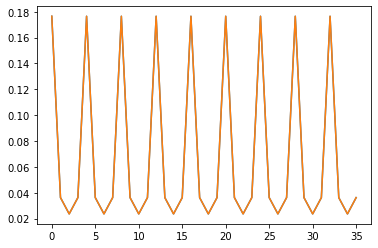

In [238]:
plt.plot(a[-1, :, 0])
plt.plot(a[-1, :, 4])

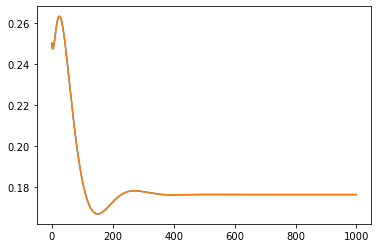

In [239]:
plt.plot(a[:, 0, 0])
plt.plot(a[:, 4, 4])

In [240]:
print(np.mean(a[-1]))
print(np.mean(b[-1]))

0.04718407181733068
0.029408062189818344


In [231]:
# a (mu = 0.11) gauss std 1
# [0.018542, 0.018542, 0.018542, 0.018543, 0.040771, 0.047111, 0.047125, 0.047125, 0.047125, 0.047125] fino a 14 e poi [0.047083, 0.043372, 0.031383, 0.031383, 0.031383, 0.031383, 0.031383] fino a 25 e poi [0.047184]

In [232]:
# b (mu = 0.11) gauss std 1
# [0.006875, 0.006875, 0.006875, 0.006876, 0.019603, 0.033463, 0.033400, 0.033400, 0.033400, 0.033400] fino a 14 e poi [0.033591, 0.022194, 0.013052, 0.013052, 0.013052, 0.013052, 0.013052] fino a 25 e poi [0.029408]

In [ ]:
# a (mu = 0.20) exp
# [0.038139, 0.035817, 0.034656, 0.033921, 0.033230]

In [ ]:
# b (mu = 0.20) exp
# [0.078876, 0.081985, 0.083398, 0.084197, 0.084808]

In [630]:
# a (mu = 0.11) exp
# [0.018558, 0.021441, 0.031349, 0.040708, 0.045662, 0.047257, 0.047161, 0.046408, 0.045490, 0.044611] [0.041796, 0.040554, 0.039524, 0.037821, 0.034962]

In [ ]:
# b (mu = 0.11) exp
# [0.006882, 0.008134, 0.013085, 0.019547, 0.025353, 0.029875, 0.033217, 0.035655, 0.037441, 0.038765] [0.041951, 0.043039, 0.043644, 0.044298, 0.045244]

In [499]:
# a (mu = 0.05) exp
# m = 1 --> 0.006842
# m = 2 --> 0.016286
# m = 3 --> 0.027740
# m = 4 --> 0.033026
# m = 5 --> 0.034134
# m = 6 --> 0.033445
# m = 7 --> 0.032350
# m = 8 --> 0.030981
# m = 9 --> 0.030040
# m = 10 --> 0.029279
# m = 15 --> 0.027585
# m = 20 --> 0.024288
# m = 25 --> 0.018151
# m = 30 --> 0.011489
# m = 35 --> 0.006596

In [402]:
# b (mu = 0.05) exp
# m = 1 --> 0.001092
# m = 2 --> 0.002837
# m = 3 --> 0.005822
# m = 4 --> 0.008466
# m = 5 --> 0.010386
# m = 6 --> 0.011706
# m = 7 --> 0.012602
# m = 8 --> 0.013251
# m = 9 --> 0.013691
# m = 10 --> 0.014008
# m = 15 --> 0.014701
# m = 20 --> 0.015222
# m = 25 --> 0.016049
# m = 30 --> 0.017076
# m = 35 --> 0.018026

In [261]:
# a (mu = 0.05) gauss std 1
# m = 1 --> 0.006501
# m = 2 --> 0.006501
# m = 3 --> 0.014368
# m = 4 --> 0.032095
# m = 5 --> 0.032816
# m = 6 --> 0.032816
# m = 7 --> 0.032816
# m = 8 --> 0.032816
# m = 9 --> 0.032816
# m = 10 -->0.032288
# dovrebbe rimanere costante fino a m = l_0*R_0 = 49

In [ ]:
# b (mu = 0.05) gauss std 1
# m = 1 --> 0.001010
# m = 2 --> 0.001010
# m = 3 --> 0.002449
# m = 4 --> 0.012627
# m = 5 --> 0.012119
# m = 6 --> 0.012119
# m = 7 --> 0.012119
# m = 8 --> 0.012119
# m = 9 --> 0.012119
# m = 10 --> 0.012502
# dovrebbe rimanere costante fino a m = l_0*R_0 = 49

In [ ]:
# a (mu = 0.05) gauss std 0.1
# m = 1 --> 0.006501
# m = 2 --> 0.006501
# m = 3 --> 0.006501
# m = 4 --> 0.032816
# m = 5 --> 0.032816
# m = 6 --> 0.032816
# m = 7 --> 0.032816
# m = 8 --> 0.032816
# m = 9 --> 0.032816
# m = 10 -->0.032288
# dovrebbe rimanere costante fino a m = l_0*R_0 = 49

In [ ]:
# b (mu = 0.05) gauss std 0.1
# m = 1 --> 0.001010
# m = 2 --> 0.001010
# m = 3 --> 0.001010
# m = 4 --> 0.012119
# m = 5 --> 0.012119
# m = 6 --> 0.012119
# m = 7 --> 0.012119
# m = 8 --> 0.012119
# m = 9 --> 0.012119
# m = 10 --> 0.012502
# dovrebbe rimanere costante fino a m = l_0*R_0 = 49